### Charge python and R libraries that will be used in the analysis

In [1]:
import pandas as pd
import re
import os
import logging
import numpy as np
from collections import defaultdict

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R 
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(magrittr))
suppressPackageStartupMessages(library(vegan))
suppressPackageStartupMessages(library(gtools))
suppressPackageStartupMessages(library(directlabels))
suppressPackageStartupMessages(library(Biostrings))
suppressPackageStartupMessages(library(hrbrthemes))
suppressPackageStartupMessages(library(data.table))
suppressPackageStartupMessages(library(phyloseq))
suppressPackageStartupMessages(library(scales))
suppressPackageStartupMessages(library(ggtree))
suppressPackageStartupMessages(library(microDecon))
suppressPackageStartupMessages(library(extrafont))
suppressPackageStartupMessages(library(gridExtra))
options(width=200)

![paper](img/paper_shot.png "Article")

![PRJNA632856](img/PRJNA632856.png "PRJNA632856 description")

## Download raw files and metadata from NCBI

In [ ]:
! wget 'http://trace.ncbi.nlm.nih.gov/Traces/sra/sra.cgi?save=efetch&rettype=runinfo&db=sra&term=PRJNA632856' -O -  > PRJNA632856.cvs

In [ ]:
%%bash
parallel --verbose -j 20 prefetch {} ::: $(awk 'BEGIN { FS="," } !/Run/{print $1}' PRJNA632856.cvs)
parallel --verbose -j 20 fastq-dump --split-files {} ::: $(awk 'BEGIN { FS="," } !/Run/{print $1}' PRJNA632856.cvs)
parallel bgzip {} ::: *.fastq
mkdir RAW && mv *gz RAW/

## Run snakemake to analyze fastq.gz raw files
### Create a config file with raw files path

In [ ]:
path = "RAW"
samples = defaultdict(dict)
seen = set()
for dir_name, sub_dirs, files in os.walk(os.path.abspath(path)):
        for fname in files:
            if ".fastq.gz" in fname:
                sample_id = fname.split(".fastq.gz")[0]
                sample_id = sample_id.replace("_1", "").replace("_2", "")
                fq_path = os.path.join(dir_name, fname)
                if "_1" in fname:
                    samples[sample_id]['R1'] = fq_path
                else:
                    samples[sample_id]['R2'] = fq_path
samples= pd.DataFrame(samples).T
samples.index.name = 'sample_id'
samples.to_csv("config.tsv",sep='\t')

### Run the snakemake pipeline 
Rules used to run the snakemake are synthetizased in the figure below. Results will be stored in the output folder. 


![pipeline](img/pipeline.png "pipeline description")

In [ ]:
# Run the loop
! snakemake --use-conda --conda-frontend mamba -j 15 && snakemake --report report.html 

## Statistical analysis on snakemake results
Results from raw files analysis are store at the output/folder

In [121]:
## Create a metadata file from metadata csv downloaded from ncbi
S = pd.read_table("PRJNA632856.cvs",sep=",",index_col=0)[["SampleName","LibraryName"]]
S[['SRR','Sample','Replicate','kit']] = S.SampleName.str.replace("_","").str.replace("replicate","Replicate").str.split('(?=[A-Z])',expand=True)
S['experiment'] = S['Sample'].apply(lambda x: 'sample' if 'Patient' in x else 'mock')
S = S[['Sample','Replicate','kit','experiment','LibraryName']]
S = S.sort_values(['experiment','Sample','kit'])

### Non specific amplification of human DNA
First we will analyse the amount of human reads found and remove with Kraken2 before running dada2

Step 1: Load table with kraken resuls

In [105]:
kraken = pd.read_table("output/bact.krak",index_col=False,sep="\t",names=['Run','bacteria','reads_bact'])
kraken['Run'] = kraken.Run.str.split('/').str[-1].str.split(".").str[0]
kraken = kraken.set_index('Run').join(S)
kraken['file_id'] = kraken.index.copy()
kraken['human'] = 100 - kraken['bacteria']
kraken = kraken.melt(id_vars=['LibraryName','Sample','experiment','Replicate','kit','file_id'], value_vars=['bacteria','human'], var_name='Lib', value_name='percentage')

Step 2: Graph results with ggplot in R 

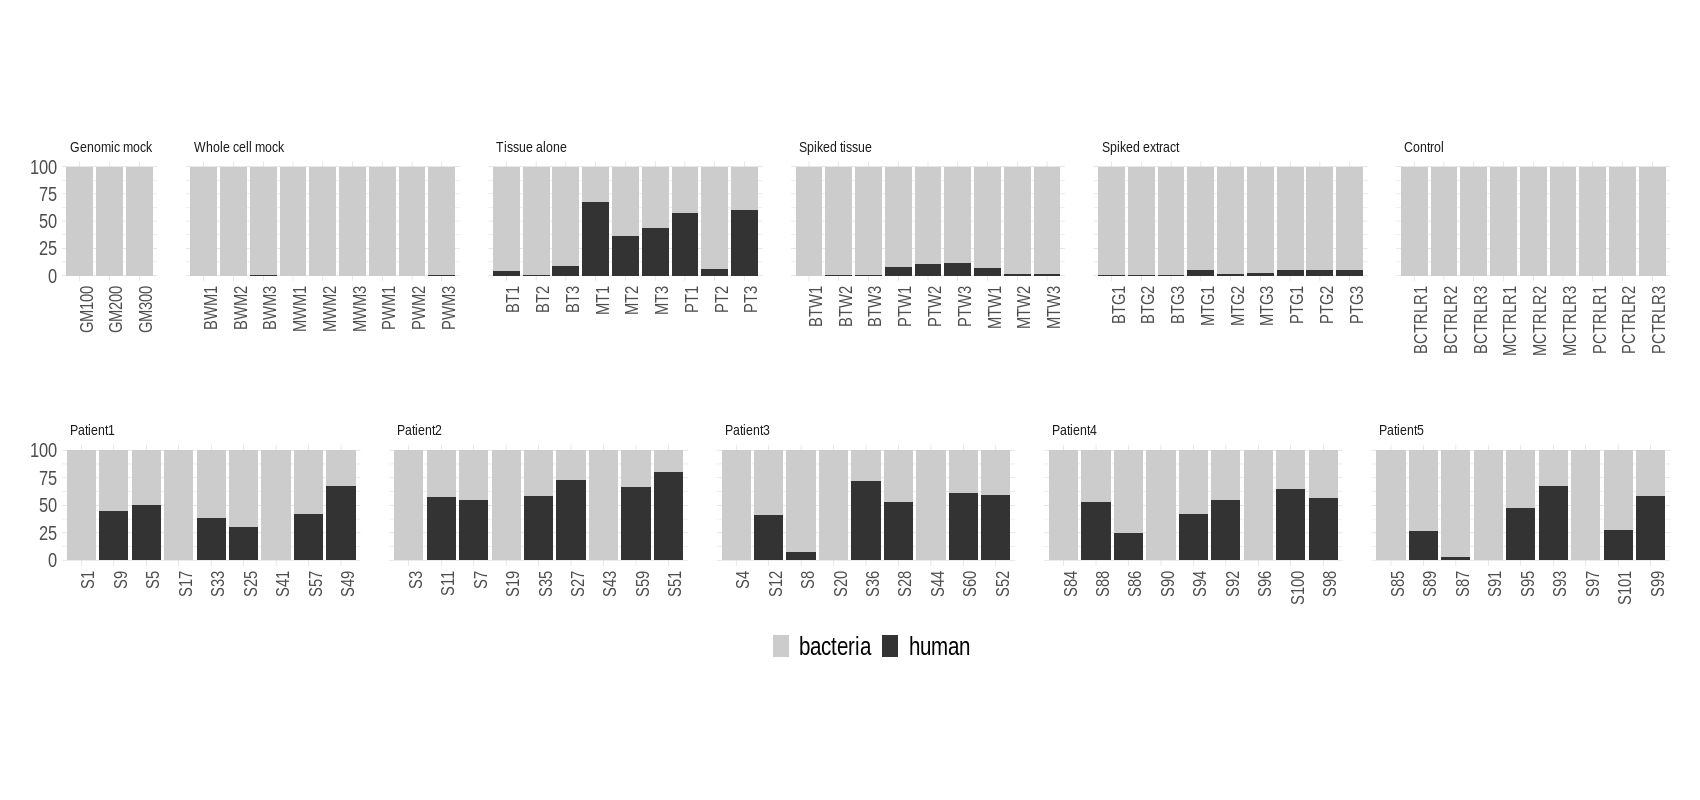

In [100]:
%%R -i kraken -w 1700 -h 800
names <- list(
  'Genomicmockcommunity'="Genomic mock",
  'Wholecellmockcommunity'="Whole cell mock",
  'Tissuealone'="Tissue alone",
  'Spikedtissue'="Spiked tissue",
  'Spikedextract'="Spiked extract",
  'Controlmock'="Control"
)
names_labeller <- function(variable,value){
  return(names[value])
}
kraken$Sample %<>% factor(levels=c('Genomicmockcommunity','Wholecellmockcommunity','Tissuealone', 'Spikedtissue','Spikedextract', 'Controlmock','Patient1','Patient2','Patient3','Patient4','Patient5'))
kraken %<>% arrange(experiment,Sample,kit,Replicate) 
levels <- kraken%$%LibraryName
kraken$LibraryName %<>% factor(levels=unique(levels))
kraken %<>% arrange(LibraryName) 
mock <- kraken  %>% filter(experiment=="mock") %>% ggplot(aes(x=LibraryName,y=percentage, fill=Lib)) + geom_bar(stat="identity")+
     facet_grid(~Sample, scales="free_x",space="free",labeller=names_labeller) +
    theme_ipsum(base_size=20) + scale_fill_grey(start = 0.8, end = 0.2) +
        theme(strip.text.x = element_text(size = 15),
        axis.title.x = element_blank(),
        axis.title.y = element_blank(),
        #panel.grid.major = element_blank(),
        axis.text.x = element_text(angle = 90, hjust = 1,size=18),
        legend.position="none")
sample <- kraken  %>% filter(experiment=="sample") %>% ggplot(aes(x=LibraryName,y=percentage, fill=Lib)) + geom_bar(stat="identity")+
     facet_grid(~Sample, scales="free_x",space="free") +
    theme_ipsum(base_size=20) + scale_fill_grey("",start = 0.8, end = 0.2) +
        theme(strip.text.x = element_text(size = 15),
        axis.title.x = element_blank(),
        axis.title.y = element_blank(),
        #panel.grid.major = element_blank(),
        axis.text.x = element_text(angle = 90, hjust = 1,size=18),
        legend.position="bottom",
        legend.text=element_text(size=25))
grid.arrange(mock,sample,heights=unit(c(100,110), c("mm", "mm")))


### Analysis of mock output for known bacteria
We will analyse the asv results obtained from the mock experiment.

- Load table with asv results

In [148]:
%%R -o X
X <- readRDS("output/results.rds")
X %<>% arrange(Phylum,Class,Order,Family,Genus,Species)

- Modify metadata, add library sizes and asv_numbers, keep only mock samples

In [123]:
%%R -o asv_numbers,library_size
asv_numbers <- colSums(dplyr::select_if(X,is.numeric) != 0) %>% enframe(name="Run", value="ASV_number")
library_size <- colSums(dplyr::select_if(X,is.numeric)) %>% enframe(name="Run", value="LibrarySize")

In [131]:
samples = library_size.set_index("Run").join(asv_numbers.set_index("Run")).join(S)

In [149]:
%%R -i samples
samples %<>% rownames_to_column(var="file_id") %>%  filter(experiment == "mock") %>% arrange(Sample,kit,Replicate)
samples$Sample %<>% factor(levels=c('Genomicmockcommunity','Wholecellmockcommunity','Tissuealone', 'Spikedtissue','Spikedextract', 'Controlmock'))
levels <- samples%$%LibraryName
samples$LibraryName %<>% factor(levels=unique(levels))
samples %<>% arrange(Sample)

In [150]:
%%R
# keep only mock data and change column names
range <-  samples%$% file_id
mock <- X %<>% dplyr::select(seqs:asv_id,!!! range)
setnames(mock, old = range, new =as.character(samples%$% LibraryName))

- Keep only genera present in the mock and merge multicopies one asv only. Create a table with absolute and relative (calculated with total number of reads per library) values

In [151]:
%%R
# Store a vector with all know genera from the mock
mock_genus <- c('Acinetobacter',
         'Actinomyces',
         'Bacillus',
         'Bacteroides',
         'Bifidobacterium',
         'Clostridium_sensu_stricto_1',
         'Cutibacterium',
         'Deinococcus',
         'Enterococcus',
         'Escherichia/Shigella',
         'Helicobacter',
         'Lactobacillus',
         'Neisseria',
         'Porphyromonas',
         'Pseudomonas',
         'Rhodobacter',
         'Staphylococcus',
         'Streptococcus')

In [152]:
%%R -i S -o mock,mock_relative
# Create the mock dataframe using only genera present in genomic mock community samples and know genera from manufacturer (ignore possible contaminations now, we will calculate the amount of other asv from relative estimates)
mock %<>% dplyr::select(-c(seqs:Family)) %>% filter(GM300 >0 | GM200 >0 | GM100 >0 ) %>% filter(Genus %in% mock_genus) %>% 
         dplyr::select(-Species,-asv_id) %>% group_by(Genus) %>% summarize_all(sum)
## Calculate relative values related to full library sizes
sample_id <- mock %>% dplyr::select(-Genus) %>% colnames()
lib <- samples %>% filter(experiment=="mock") %>% arrange(Sample,kit,Replicate) %>% rownames_to_column(var="Run") %$% LibrarySize
names(lib) <- samples %>% filter(experiment=="mock") %>% arrange(Sample,kit,Replicate) %>% rownames_to_column(var="Run") %$% LibraryName
mock_matrix <- mock %>% column_to_rownames(var="Genus") %>% as.matrix()
mock_relative <- sweep(mock_matrix, 2, lib, `/`) %>% as.data.frame() 
#>% rownames_to_column(var="Genus") %>% tibble() 

In [153]:
%%R -i S 
apply(mock_relative,2, function (x) (1 - sum(x))*100) %>% enframe(name="LibraryName", value="contamination") %>% left_join(S,by="LibraryName")

# A tibble: 48 x 6
   LibraryName contamination Sample                 Replicate  kit       experiment
   <chr>               <dbl> <chr>                  <chr>      <chr>     <chr>     
 1 GM100              0.0394 Genomicmockcommunity   Replicate1 NA        mock      
 2 GM200              0.163  Genomicmockcommunity   Replicate2 NA        mock      
 3 GM300              0.0337 Genomicmockcommunity   Replicate3 NA        mock      
 4 BWM1               2.60   Wholecellmockcommunity Replicate1 Blood     mock      
 5 BWM2               3.29   Wholecellmockcommunity Replicate2 Blood     mock      
 6 BWM3               1.78   Wholecellmockcommunity Replicate3 Blood     mock      
 7 MWM1               1.62   Wholecellmockcommunity Replicate1 Microbial mock      
 8 MWM2               0.479  Wholecellmockcommunity Replicate2 Microbial mock      
 9 MWM3               0.623  Wholecellmockcommunity Replicate3 Microbial mock      
10 PWM1               4.02   Wholecellmockcommunity Repli

In [103]:
%%R -i S


In [45]:
mock.head()

,Genus,BCTRLR2,BCTRLR3,BCTRLR1,MCTRLR3,MCTRLR1,MCTRLR2,PCTRLR1,PCTRLR3,PCTRLR2,...,PT2,BWM3,BWM1,BWM2,MWM1,MWM2,MWM3,PWM2,PWM3,PWM1
1,Acinetobacter,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3103.0,2520.0,1517.0,1288.0,1493.0,1562.0,1638.0,1324.0,1537.0
2,Actinomyces,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,84.0,435.0,76.0,63.0,208.0,91.0,114.0,253.0,250.0
3,Bacillus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4857.0,4521.0,3129.0,4076.0,3596.0,3514.0,2909.0,2284.0,1681.0
4,Bacteroides,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,191.0,189.0,181.0,245.0,85.0,145.0,36.0,231.0,137.0
5,Bifidobacterium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,56.0,4.0,0.0,177.0,40.0,102.0,186.0,79.0,0.0
